### Import the libraries and define all the utility functions/classes

#### Import libraries

In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
import pickle

from collections import deque
from scipy.ndimage.measurements import label

from sklearn.utils import shuffle
from skimage.util.shape import view_as_windows

from keras.layers.core import Dense, Lambda, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers import Convolution2D
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

Using TensorFlow backend.


#### Define image processing functions

In [2]:
#Wrapper for BGR to RGB conversion
def BGR2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Wrapper for BGR to Gray conversion
def BGR2GRAY(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Wrapper for RGB to Gray conversion
def RGB2GRAY(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#For use with labeled heatmaps
def draw_labeled_bboxes(img, labels):
    draw_img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_img, tuple(bbox[0]), tuple(bbox[1]), (100,255,0), 3)
    # Return the image
    return draw_img

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#Perform prediction on views generated from image
def search_windows(views, model):   
    #Generate predictions for entire batch of views
    predictions = model.predict(views, batch_size = len(views))
    return predictions.reshape(-1)

#Create views of image for input into the neural network
#http://scikit-image.org/docs/stable/api/skimage.util.html#view-as-windows
def create_views(img, window_size, xy_overlap, xlim, ylim, window_scale):
    views = []
    for idx, scale in enumerate(window_scale):
        #Determine step size based on overlap
        nx_pix_per_step = np.int(window_scale[idx]*window_size[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(window_scale[idx]*window_size[1]*(1 - xy_overlap[1]))
        #Generate views one channel at a time
        image_views0 = view_as_windows(img[ylim[idx][0]:ylim[idx][1],xlim[idx][0]:xlim[idx][1],0], 
                                       (window_scale[idx]*window_size[0], window_scale[idx]*window_size[1]),
                                       (nx_pix_per_step, ny_pix_per_step))
        image_views1 = view_as_windows(img[ylim[idx][0]:ylim[idx][1],xlim[idx][0]:xlim[idx][1],1], 
                                       (window_scale[idx]*window_size[0], window_scale[idx]*window_size[1]),
                                       (nx_pix_per_step, ny_pix_per_step))
        image_views2 = view_as_windows(img[ylim[idx][0]:ylim[idx][1],xlim[idx][0]:xlim[idx][1],2], 
                                       (window_scale[idx]*window_size[0], window_scale[idx]*window_size[1]),
                                       (nx_pix_per_step, ny_pix_per_step))
        #Stack the channels back into an image
        image_views = np.stack((image_views0,image_views1,image_views2), -1)
        #Reshape the views to (n_samples, image height, image width, channels)
        image_views = np.reshape(image_views, (-1, int(window_scale[idx]*window_size[0]), 
                                               int(window_scale[idx]*window_size[1]),3))
        #Equalize and resize the images
        #image_views = clahe_equalize_RGB_set(image_views)
        image_views = resize(image_views)
        #Append the image view to the views array for each scale
        views.extend(image_views)
    #print("Shape of views is:", np.asarray(views).shape)
    return np.asarray(views)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
    #return np.asarray(window_list)    

#Equalize a set of gray images
def clahe_equalize(img_set):
    clahe_img_set = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    for img in img_set:
        clahe_img_set.append(np.expand_dims(clahe.apply(img), axis = 2))
    return clahe_img_set

#Equalize a set of RGB images
def clahe_equalize_RGB_set(img_set):
    clahe_RGB_img_set = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    for img in img_set:
        y, u, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YUV))
        y = clahe.apply(y)
        img = cv2.merge((y,u,v))
        img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
        clahe_RGB_img_set.append(img)
    return clahe_RGB_img_set

#Equalize a single RGB image
def clahe_equalize_RGB_img(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    y, u, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YUV))
    y = clahe.apply(y)
    img = cv2.merge((y,u,v))
    img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
    return clahe_RGB_img

#Resize set of images to (32x32) for input into the neural network
def resize(img_set):
    resized_img_set = []
    for img in img_set:
        resized = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA )
        resized_img_set.append(resized)
    return np.asarray(resized_img_set, dtype = np.uint8)

#Read images given a color space
def read_images(files, color_space='RGB'):
    # Create aarray to hold images
    n_images = len(files)
    if color_space == 'GRAY':
        images = np.empty([n_images, 64, 64], dtype = np.uint8)
    else:
        images = np.empty([n_images, 64, 64, 3], dtype = np.uint8)
    # Iterate through the list of images
    for idx, file in enumerate(files):
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
            elif color_space == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else: feature_image = BGR2RGB(image)   
        images[idx] = feature_image
    return images

#### Define ImageProcess Class

In [42]:
class ImageProcessor: 
    
    def __init__(self, model):
        
        self.model = model #model to use for predictions
        self.xy_window = (80, 80) #size of initial window
        self.window_scale = (1.25, 1.5625, 1.875) #window scales to use
        self.x_start_stop = [[575, 1280], [400, 1280]] #start and stop x-coordinates to search
        self.y_start_stop = [[400, 520], [400, 580], [400, 700]] #start and stop y-coordinates to search
        self.xy_overlap = (0.75, 0.75) #overlap of search windows
        self.pred_threshold = 0.7
        self.smooth_count = 5 # Number of frames to average over
        self.threshold = 5 #threshold for detection
        self.heatmaps_list = deque(maxlen=self.smooth_count) #deque of heatmaps to smooth
        
        
    def __sum_heatmap(self, heatmaps_list, thresh):
        smooth_heatmap = 0
        #Sum the hot pixel values in the heatmap upto a maximum of smooth_count
        for i in range(len(heatmaps_list)):
            smooth_heatmap += heatmaps_list[i]
        #Apply the threshold before returning the heatmap
        return apply_threshold(smooth_heatmap, thresh)
    
        
    def vehicle_detection(self, img):
       
        windows = []
        detection_windows = []
        detection_rectangles = [] #Used only for cv2.groupRectangles
        hot_windows = [] #Used only for cv2.groupRectangles
        trans_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        for i, scale in enumerate(self.window_scale):
        #Generate (x,y) coordinates for all windows that will be used
            windows.extend(slide_window(trans_img, x_start_stop=self.x_start_stop[i], y_start_stop=self.y_start_stop[i], 
                                   xy_window=[int(dim*scale) for dim in self.xy_window], xy_overlap=self.xy_overlap))
        windows = np.asarray(windows)
        #Generate views based on the same parameters as the slide_windows() function
        views = create_views(trans_img, xy_window, self.xy_overlap, self.x_start_stop, self.y_start_stop, self.window_scale)
        #Get predictions on all the views and reshape for boolean masking
        predictions = search_windows(views, self.model)
        #If detections are found, append the detected windows if the probability is greater than a threshold
        if len(predictions[predictions>=self.pred_threshold]) > 0:
            detection_windows.extend(windows[predictions>=self.pred_threshold])

        #''' #Comment out this line to run the pipeline using heatmaps
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap ,detection_windows)

        #####Use for running on images####
        heatmap = apply_threshold(heatmap, self.threshold)
        labels = label(heatmap)

        ###Use for running on videos####
        #self.heatmaps_list.append(heatmap)
        #smooth_heatmap = self.__sum_heatmap(self.heatmaps_list, self.threshold)
        #labels = label(smooth_heatmap)

        ##Draw labels or detection windows
        final_img = draw_labeled_bboxes(img, labels)
        #final_img = draw_boxes(img, detection_windows)
        #''' #Comment out this line to run the pipeline using heatmaps

        ''' #Comment out this line to run the pipeline using cv2.GroupRectangles
        ##Use cv2.Group rectangles
        groupThresh = 1
        eps = 1

        if detection_windows:
            for win in detection_windows:
                x = (win[1][0] + win[0][0])/2
                y = (win[1][1] + win[0][1])/2
                w = win[1][0] - win[0][0]
                h = win[1][1] - win[0][1]
                detection_rectangles.append((x,y,w,h))

        hot_rectangles = cv2.groupRectangles(detection_rectangles, groupThresh, eps)

        if any(map(len, hot_rectangles)):
            for rect in hot_rectangles[0]:
                hot_windows.append(((rect[0]-(rect[2]//2), rect[1]-(rect[3]//2)),  
                                     (rect[0]+(rect[2]//2), rect[1]+(rect[3]//2))))

        final_img = draw_boxes(img, hot_windows, color = (100,255,0))
        ''' #Comment out this line to run the pipeline using cv2.GroupRectangles

        return final_img

### Build & train the Neural Network

#### Process the data

Read in all the data

In [46]:
notcars = glob.glob('.\\data\\non-vehicles\\**\\*.png', recursive=True)
cars = glob.glob('.\\data\\vehicles\\**\\*.png', recursive=True)
test_image = cv2.imread(cars[0])
test_image = BGR2RGB(test_image)

print("Number of car images:", len(cars))
print("Number of background images:", len(notcars))
print("Image size for the data set is:", test_image.shape)
print("Total number of samples is:", len(cars) + len(notcars))

color_space = 'LUV'
t=time.time()
car_images = read_images(cars, color_space=color_space)
notcar_images = read_images(notcars, color_space=color_space)
t2 = time.time()
print(round(t2-t, 2), 'seconds to read in images...')

Number of car images: 8792
Number of background images: 8968
Image size for the data set is: (64, 64, 3)
Total number of samples is: 17760
34.68 seconds to read in images...


Process the images and create the labels:

In [47]:
t=time.time()
# Define the labels vector
y = np.hstack((np.ones(len(car_images)), np.zeros(len(notcar_images)))).reshape(-1,1)
#Equalize and resize the training data
#car_images_eq = clahe_equalize_RGB_set(car_images)
#notcar_images_eq = clahe_equalize_RGB_set(notcar_images)
#X = np.concatenate((car_images_eq, notcar_images_eq), 0)
X = np.concatenate((car_images, notcar_images), 0) #No equalization
X = resize(X)
t2 = time.time()
print(round(t2-t, 2), 'seconds to process data...')
X, y = shuffle(X, y)

0.35 seconds to process data...


#### Initalize & train the classifier

Define LeNet-5 in Keras and initialize

In [48]:
#Define the function to build the model
def build_LeNet5(keep_prob):
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, name = 'Normalization', input_shape=(32, 32, 3)))
    model.add(Convolution2D(6, 5, 5, init = 'normal', activation = 'elu', border_mode = 'valid', subsample = (1,1), 
                            bias=True, name = 'Conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPool1'))
    model.add(Convolution2D(16, 5, 5, init = 'normal', activation = 'elu', border_mode = 'valid', subsample = (1,1), 
                            bias=True, name = 'Conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPool2'))
    model.add(Flatten(name = 'Flatten'))
    model.add(Dense(120, activation = 'elu', name = 'FC1'))
    model.add(Dropout(keep_prob, name = 'Dropout1'))
    model.add(Dense(84, activation = 'elu', name = 'FC2'))
    model.add(Dropout(keep_prob, name = 'Dropout2'))
    #Sigmoid activation function is used to get a probability output
    model.add(Dense(1, activation = 'sigmoid', name = 'Output'))
    model.compile(optimizer = 'adam', loss =  'binary_crossentropy', metric = ['accuracy'])
    
    return model

#Define the dropout hyper-parameter    
keep_prob = 0.5

#Build & compile the model
LeNet5 = build_LeNet5(keep_prob)
print(LeNet5.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Normalization (Lambda)           (None, 32, 32, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 28, 28, 6)     456         Normalization[0][0]              
____________________________________________________________________________________________________
MaxPool1 (MaxPooling2D)          (None, 14, 14, 6)     0           Conv1[0][0]                      
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 10, 10, 16)    2416        MaxPool1[0][0]                   
___________________________________________________________________________________________

Train LeNet-5 with training data and save the model

In [50]:
#Terminate the training early if the validation loss stops dropping to prevent over fitting
t = time.time()
TrainingCallbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 1, verbose = 1)]
training_history = LeNet5.fit(X, y, nb_epoch=15, callbacks = TrainingCallbacks, validation_split=0.2, 
                              batch_size = 512, verbose = 2)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train model...')
#LeNet5.save('LeNet5_kp05_LUV.h5')

Train on 14208 samples, validate on 3552 samples
Epoch 1/15
15s - loss: 0.3025 - val_loss: 0.2633
Epoch 2/15
15s - loss: 0.2619 - val_loss: 0.2304
Epoch 3/15
16s - loss: 0.2406 - val_loss: 0.2018
Epoch 4/15
17s - loss: 0.2074 - val_loss: 0.2000
Epoch 5/15
14s - loss: 0.1937 - val_loss: 0.1730
Epoch 6/15
15s - loss: 0.1681 - val_loss: 0.1448
Epoch 7/15
19s - loss: 0.1463 - val_loss: 0.1517
Epoch 8/15
15s - loss: 0.1418 - val_loss: 0.1240
Epoch 9/15
15s - loss: 0.1283 - val_loss: 0.1241
Epoch 10/15
15s - loss: 0.1178 - val_loss: 0.1158
Epoch 00009: early stopping
160.38 seconds to train model...


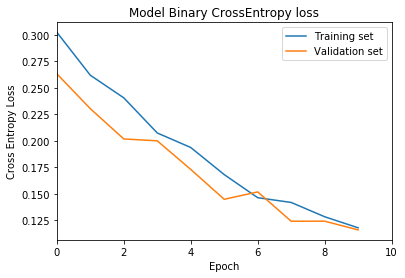

In [54]:
#Visualize the training and validation loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model Binary CrossEntropy loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xlim([0,10])
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.savefig('.\\output_images\\training_history.png')
plt.show()

In [64]:
print(training_history.history.keys())

dict_keys(['loss', 'val_loss'])


### Perform predictions using the ImageProcessor Class

Load the classifier and scaler using pickle

In [4]:
#Load a previously trained model
LeNet5 = load_model('LeNet5_kp05_LUV.h5')

#### Read in all the test images

Test images shape is: (6, 720, 1280, 3)


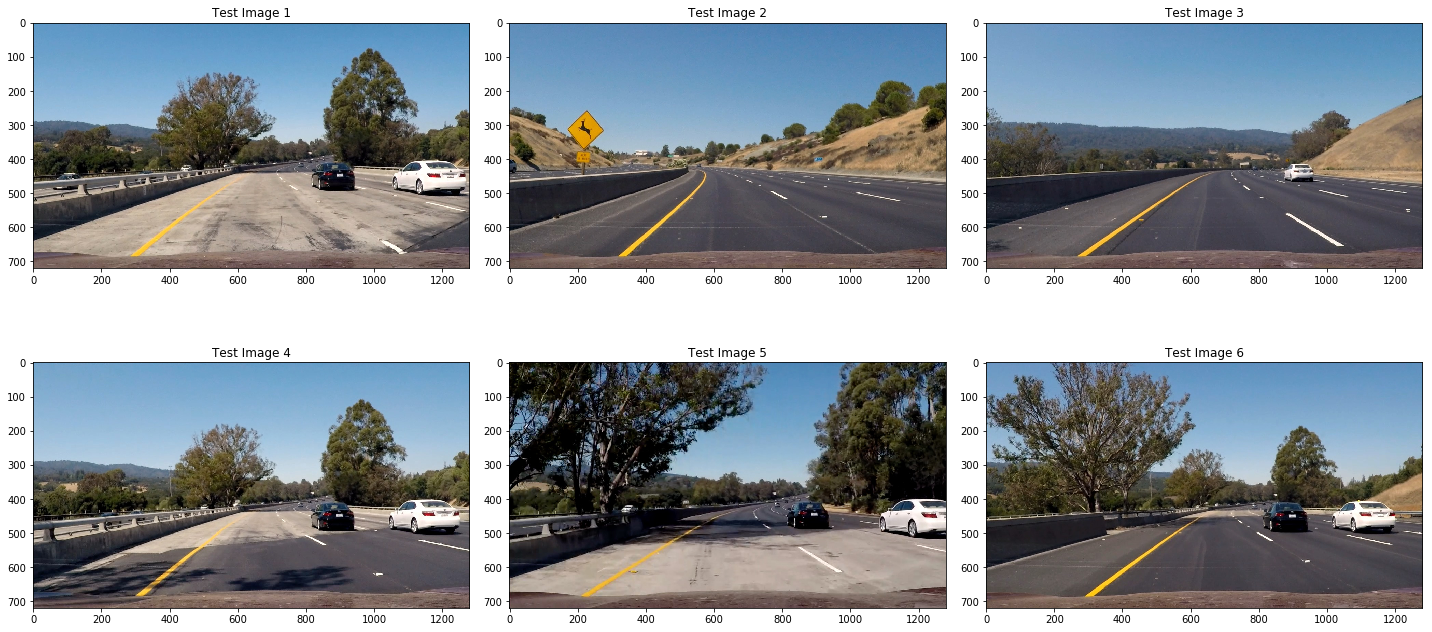

In [5]:
test_files = glob.glob('.\\test_images\*.jpg')
test_images = []
for file in test_files:
    test_image = cv2.imread(file)
    test_image = BGR2RGB(test_image)
    test_images.append(test_image)

test_images = np.asarray(test_images)
print("Test images shape is:", test_images.shape)

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20,10))
for idx, image in enumerate(test_images):
    plt.subplot(nrows,ncols, idx+1)
    plt.imshow(test_images[idx])
    plt.title('Test Image {:d}'.format(idx+1))
fig.tight_layout()
plt.show()

#### Visualize & search the windows

Visualize the windows on each test image

Total # of windows: 238


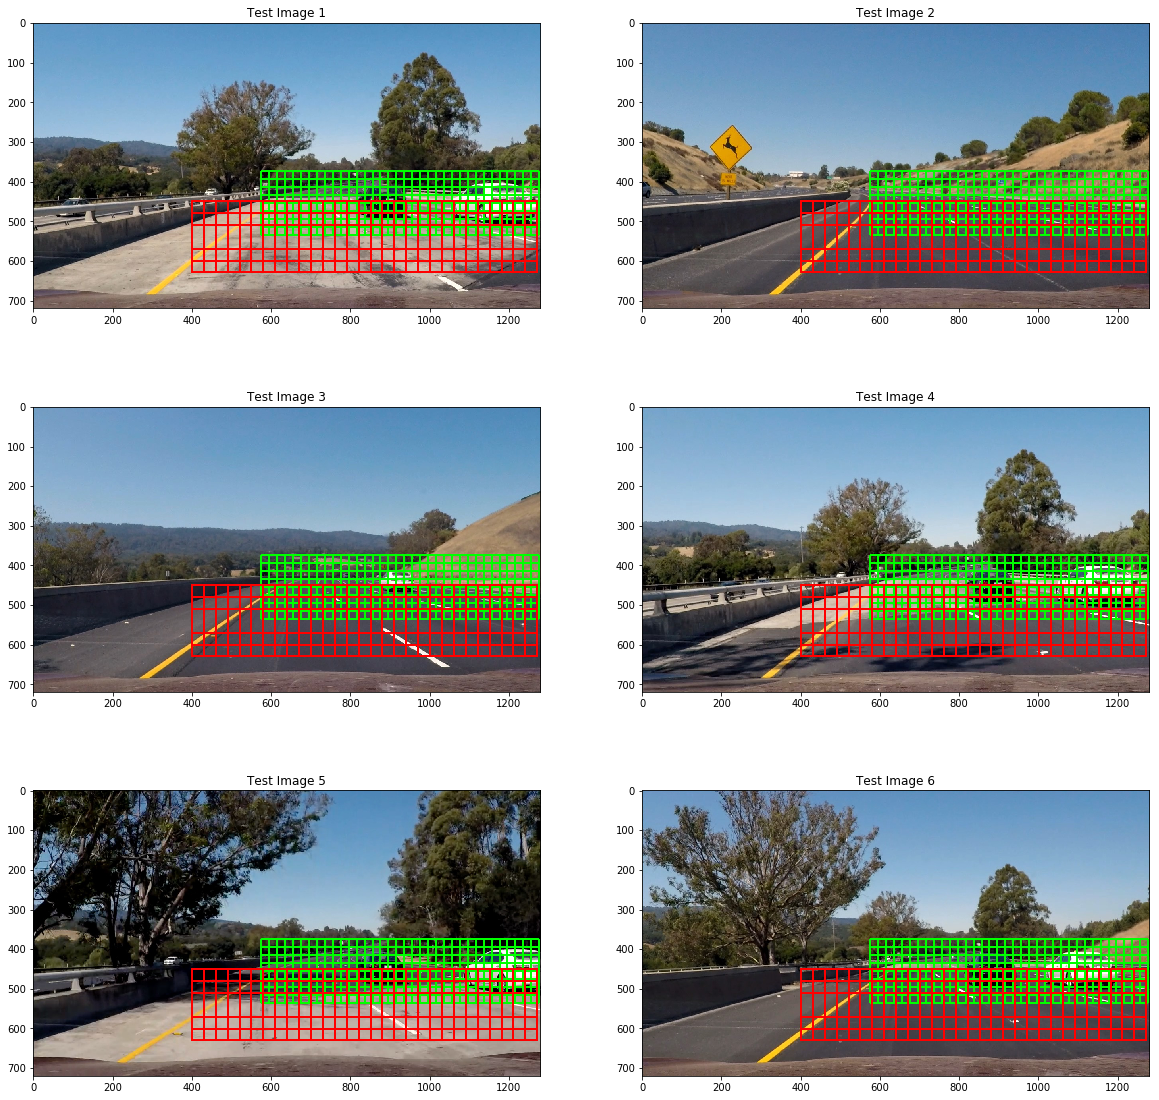

In [56]:
#Variables for sliding windows
window_scale = (1.0, 1.5)
x_start_stop = [[575, 1280], [400, 1280]]
y_start_stop = [[375, 550], [450, 650]]
xy_window = (80, 80)
xy_overlap = (0.75, 0.75)
color_values = [(0,255,0), (255,0,0)]

plt.figure(figsize=(20,20))
for idx, image in enumerate(test_images):
    n_windows = 0
    for i, scale in enumerate(window_scale):
        windows = slide_window(image, x_start_stop=x_start_stop[i], y_start_stop=y_start_stop[i], 
                                    xy_window=[int(dim*window_scale[i]) for dim in xy_window], xy_overlap=xy_overlap)
        image = draw_boxes(image, windows, color_values[i])
        n_windows += len(windows)
    plt.subplot(3,2,idx+1)
    plt.imshow(image)
    plt.title("Test Image {:d}".format(idx+1))

#plt.savefig('.\\output_images\\NN_windows.png')
print("Total # of windows:", n_windows)
plt.show()

In [43]:
#Instantiate object and set attributes
processor = ImageProcessor(LeNet5)
processor.window_scale = window_scale
processor.x_start_stop = x_start_stop
processor.y_start_stop = y_start_stop
processor.xy_overlap = xy_overlap
processor.xy_window = xy_window
processor.threshold = 1 #Thresholding for heatmap smoothing - use 1 for images and 9 for videos
processor.smooth_count = 15
processor.pred_threshold = 0.6 #Probability threshold for positive classification result

Search each of the test images

Average Image processing time: 0.18 seconds


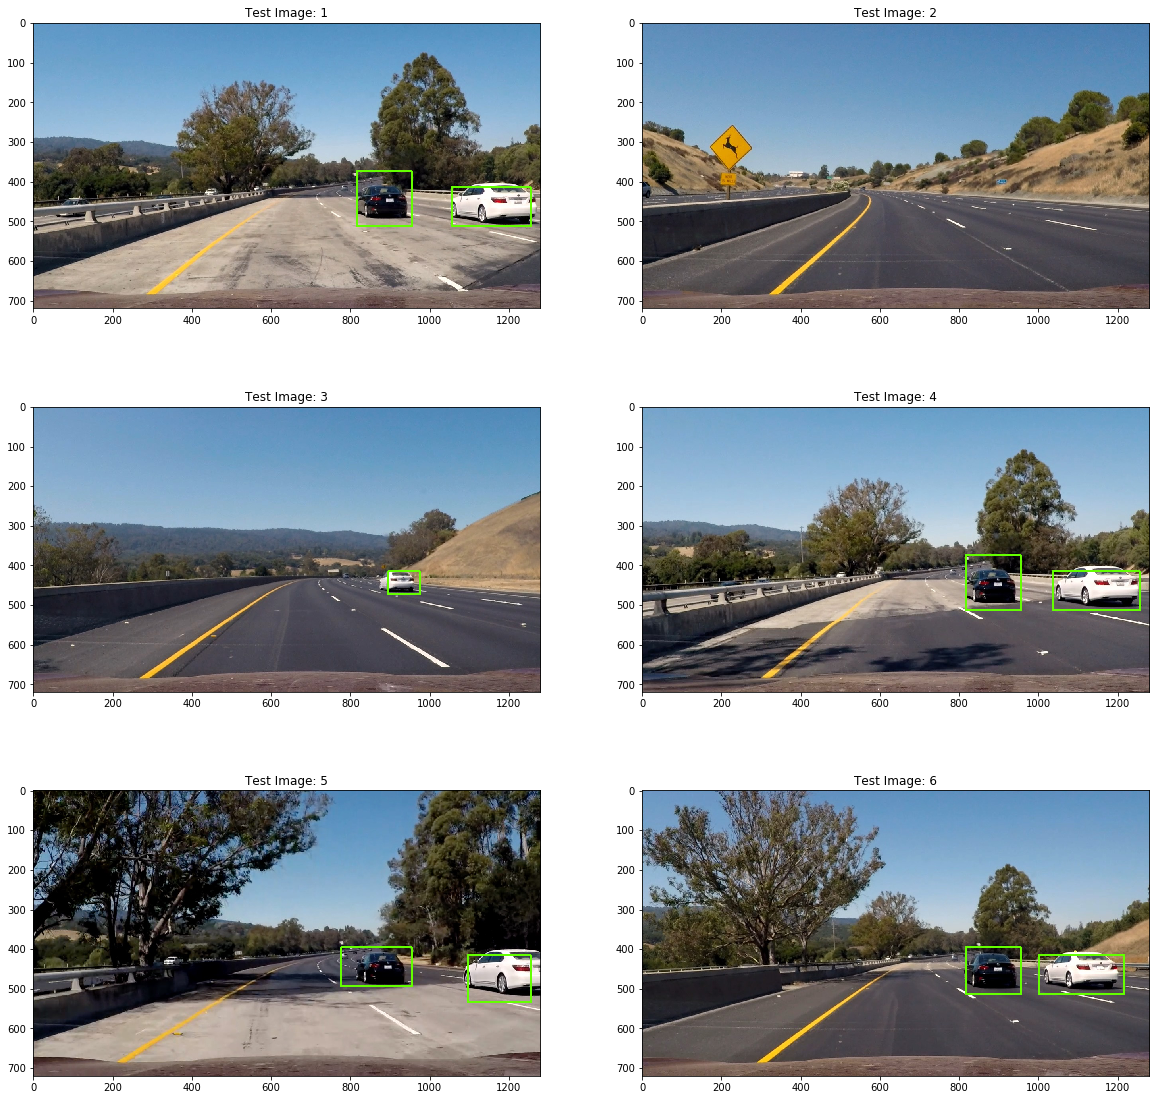

In [60]:
#Update the heatmaps section of the vehicle detection function before running
plt.figure(figsize=(20,20))
total_time = 0
for idx, image in enumerate(test_images):
    t = time.time()
    output_image = processor.vehicle_detection(image)
    t2 = time.time()
    total_time += round(t2-t,2)
    plt.subplot(3,2,idx+1)
    plt.title("Test Image: {:d}".format(idx+1))
    plt.imshow(output_image)
print("Average Image processing time: {:.2f} seconds".format(total_time/(idx+1)))
plt.savefig('.\\output_images\\NN_detections.png')
plt.show()

In [41]:
project_output = '.\\output_videos\\project_output_NN.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(25,40)
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(processor.vehicle_detection)
%time clip.write_videofile(project_output, audio=False)
clip.reader.close()

[MoviePy] >>>> Building video .\output_videos\project_output_NN.mp4
[MoviePy] Writing video .\output_videos\project_output_NN.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:52<00:00,  3.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: .\output_videos\project_output_NN.mp4 

Wall time: 5min 53s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))